In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.linear_model import Lasso, MultiTaskLasso 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import QuantileRegressor, PassiveAggressiveRegressor 

In [3]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

In [4]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge

In [5]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [6]:
from sklearn.neural_network import MLPRegressor

In [7]:
from sklearn.isotonic import IsotonicRegression

In [8]:
pd.options.display.max_rows = None

Obrim el dataframe que vam crear en el preprocessat de dades.

In [10]:
datos = pd.read_csv('df/db_df.csv')
datos.head()

,Unnamed: 0,Nivell absolut (msnm),Percentatge volum embassat (%),Volum embassat (hm3),PPT
0,2000-01-01,147.27,50.8,31.02,0.0
1,2000-01-02,147.27,50.8,31.02,0.0
2,2000-01-03,147.27,50.8,31.02,0.0
3,2000-01-04,147.27,50.8,31.02,0.0
4,2000-01-05,147.28,50.8,31.04,0.0


Com que només farem servir finalment el nivell absolut en els nostres models, esborrarem la resta de les columnes.

In [11]:
datos.drop(['Percentatge volum embassat (%)'], axis = 'columns', inplace=True)
datos.drop(['Volum embassat (hm3)'], axis = 'columns', inplace=True)
datos.drop(['PPT'], axis = 'columns', inplace=True)

In [12]:
datos.head()

,Unnamed: 0,Nivell absolut (msnm)
0,2000-01-01,147.27
1,2000-01-02,147.27
2,2000-01-03,147.27
3,2000-01-04,147.27
4,2000-01-05,147.28


Com que les dates no s'han guardat al csv com a index si no com a columna, amb nom Unnamed: 0, haurem de transformar-la a format datetime per després fer-la servir com a index. finalment establim una freqüencia diaria del dataframe i esborrem la columna Unnamed: 0.

In [13]:
datos['Dia'] = pd.to_datetime(datos['Unnamed: 0'], format='%Y/%m/%d')
datos = datos.set_index('Dia')
datos = datos.asfreq('D')
datos = datos.sort_index()
datos.drop(['Unnamed: 0'], axis = 'columns', inplace=True)

In [14]:
datos.head()

,Nivell absolut (msnm)
Dia,
2000-01-01,147.27
2000-01-02,147.27
2000-01-03,147.27
2000-01-04,147.27
2000-01-05,147.28


Farem servir només les dades fins a l'1 de gener del 2022,  per tenir una serie histórica amb anys sencers, que ens pot ajudar a l'hora de fer el model.

In [145]:
datos = datos.loc['2000-01-01':'2022-01-01']

Comprovem que el número de registres i el tipus de dades sigui el correcte.

In [16]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8037 entries, 2000-01-01 to 2022-01-01
Freq: D
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Nivell absolut (msnm)  8037 non-null   float64
dtypes: float64(1)
memory usage: 125.6 KB


A continuació separarem les dades en un conjunt d'entrenament i de test. 
Per al conjunt de test farem servir 365 observacions, o sigui un any, i la resta per l'entrenament.

Fechas train : 2000-01-01 00:00:00 --- 2021-01-01 00:00:00  (n=7672)
Fechas test  : 2021-01-02 00:00:00 --- 2022-01-01 00:00:00  (n=365)


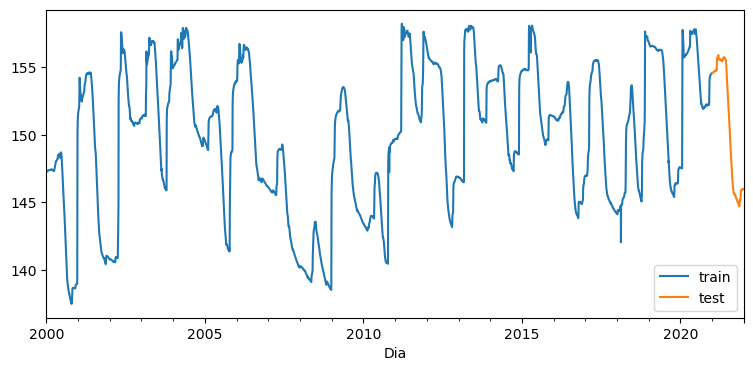

In [146]:
# Separació dades train-test
# ==============================================================================

steps = 365
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

# gràfica del train i test
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['Nivell absolut (msnm)'].plot(ax=ax, label='train')
datos_test['Nivell absolut (msnm)'].plot(ax=ax, label='test')
ax.legend()

A continuació farem servir la funció ForecasterAutoreg de la llibreria skforecast, que ens permet fer servir un model regressiu qualsevol, dintre de tots aquells que es poden fer servir amb la llibreria scikit-learn, per fer un model autoregressiu, amb els lags que nosaltres escollim. 
Com a aclaració, els lags son les observacions anteriors a les dades que volem predir.

## LinearRegression

Començarem per un dels models de regressió més senzills però no per això pitjors, encara que té pocs paràmetres per poder millorar la seva performance.

In [147]:
# Crear forecaster
# ==============================================================================
forecaster_lr = ForecasterAutoreg(
                regressor = LinearRegression(),
                lags = 6180
             )

forecaster_lr.fit(y=datos_train['Nivell absolut (msnm)'])
forecaster_lr

ForecasterAutoreg 
Regressor: LinearRegression() 
Lags: [   1    2    3 ... 6178 6179 6180] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6180 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2000-01-01 00:00:00'), Timestamp('2021-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False} 
Creation date: 2023-01-31 12:37:50 
Last fit date: 2023-01-31 12:37:53 
Skforecast version: 0.6.0 
Python version: 3.9.13 

Fem les prediccions per un any, que coincidiran amb l'any del conjunt de test, i així veurem com s'ajusta la predicció del nostre model a la realitat.

In [148]:
# Prediccions
# ==============================================================================
steps = 365
predicciones_lr = forecaster_lr.predict(steps=steps)

Ara compararem els valors del conjunt de test amb les prediccions del nostre model i n'extreurem les metriques Mean Squared Error i R2 Score, que ens ajudaran a mesurar com de bé o de malament prediu el nostre model.

In [149]:
# Metriques
# ==============================================================================
error_mse_lr = mean_squared_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_lr
            )
error_mae_lr = mean_absolute_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_lr
            )
score_lr = r2_score(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_lr
            )
print(f"Error de test (mae): {error_mae_lr}")
print(f"Error de test (mse): {error_mse_lr}")
print(f"R2 Score: {score_lr}")

Error de test (mae): 1.6204177398487152
Error de test (mse): 5.354497401829725
R2 Score: 0.7377377856247607


Veiem que l'error de test no és molt gran i l'R2 score no està malament, amb un 73,7%.

A continuació farem una gràfica per veure com encaixen les prediccions en relació a la realitat.

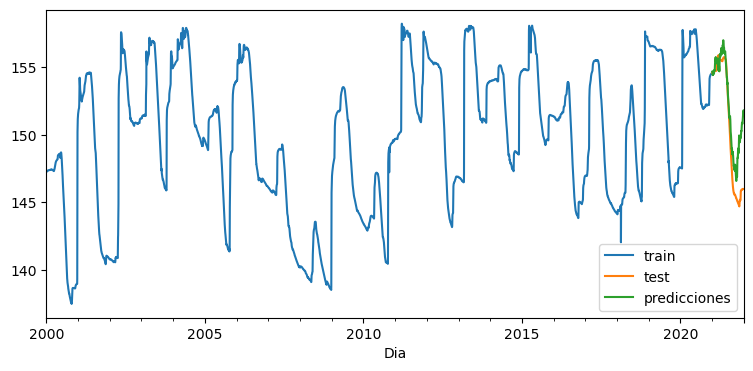

In [150]:
# Gràfic
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['Nivell absolut (msnm)'].plot(ax=ax, label='train')
datos_test['Nivell absolut (msnm)'].plot(ax=ax, label='test')
predicciones_lr.plot(ax=ax, label='predicciones')
ax.legend();

Veiem que a l'inici i fins una mica més de la meitat del conjunt de test, les prediccions del nostr emodel encaixen força bé, però cap al final el nostre model prediu valors per sobre dels reals.

Ara continuarem provan diferents models regressius a veure si trobem cap que millori els resultats del nostre primer model.

## Ridge

In [151]:
# Crear forecaster
# ==============================================================================
forecaster_ridge = ForecasterAutoreg(
                regressor = Ridge(random_state=42),
                lags = 6180
             )

forecaster_ridge.fit(y=datos_train['Nivell absolut (msnm)'])
forecaster_ridge

ForecasterAutoreg 
Regressor: Ridge(random_state=42) 
Lags: [   1    2    3 ... 6178 6179 6180] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6180 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2000-01-01 00:00:00'), Timestamp('2021-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': 42, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2023-01-31 12:38:37 
Last fit date: 2023-01-31 12:38:38 
Skforecast version: 0.6.0 
Python version: 3.9.13 

In [152]:
# Prediccions
# ==============================================================================
steps = 365
predicciones_ridge = forecaster_ridge.predict(steps=steps)

In [153]:
# Metriques
# ==============================================================================
error_mse_ridge = mean_squared_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_ridge
            )
error_mae_ridge = mean_absolute_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_ridge
            )
score_ridge = r2_score(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_ridge
            )
print(f"Error de test (mae): {error_mae_ridge}")
print(f"Error de test (mse): {error_mse_ridge}")
print(f"R2 Score: {score_ridge}")

Error de test (mae): 1.6816408942954393
Error de test (mse): 5.62401171416292
R2 Score: 0.7245370283820416


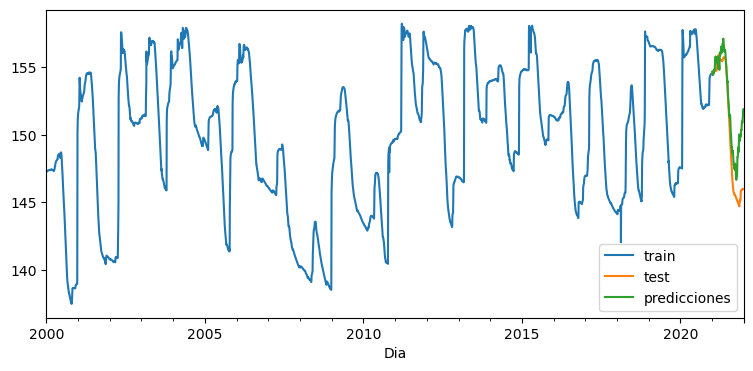

In [155]:
# Gràfic
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['Nivell absolut (msnm)'].plot(ax=ax, label='train')
datos_test['Nivell absolut (msnm)'].plot(ax=ax, label='test')
predicciones_ridge.plot(ax=ax, label='predicciones')
ax.legend();

## PassiveAggressiveRegressor

In [156]:
# Crear i entrenar forecaster
# ==============================================================================
forecaster_PAR = ForecasterAutoreg(
                regressor =  PassiveAggressiveRegressor(random_state=42),
                lags = 6180,
                #transformer_y = MinMaxScaler()
             )

forecaster_PAR .fit(y=datos_train['Nivell absolut (msnm)'])
forecaster_PAR 

ForecasterAutoreg 
Regressor: PassiveAggressiveRegressor(random_state=42) 
Lags: [   1    2    3 ... 6178 6179 6180] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6180 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2000-01-01 00:00:00'), Timestamp('2021-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'C': 1.0, 'average': False, 'early_stopping': False, 'epsilon': 0.1, 'fit_intercept': True, 'loss': 'epsilon_insensitive', 'max_iter': 1000, 'n_iter_no_change': 5, 'random_state': 42, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-01-31 12:39:03 
Last fit date: 2023-01-31 12:39:05 
Skforecast version: 0.6.0 
Python version: 3.9.13 

In [157]:
# Prediccions
# ==============================================================================
steps = 365
predicciones_PAR = forecaster_PAR.predict(steps=steps)

In [158]:
# Metriques
# ==============================================================================
error_mse_PAR = mean_squared_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_PAR
            )
error_mae_PAR = mean_absolute_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_PAR
            )
score_PAR = r2_score(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_PAR
            )
print(f"Error de test (mae): {error_mae_PAR}")
print(f"Error de test (mse): {error_mse_PAR}")
print(f"R2 Score: {score_PAR}")

Error de test (mae): 1.528258007770745
Error de test (mse): 5.035074174245105
R2 Score: 0.7533830715783222


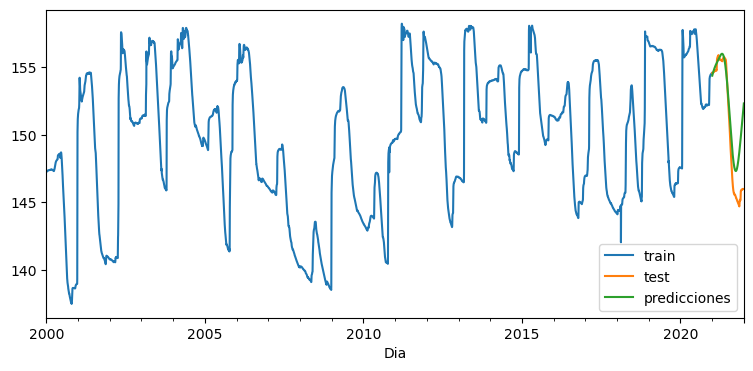

In [159]:
# Gràfic
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['Nivell absolut (msnm)'].plot(ax=ax, label='train')
datos_test['Nivell absolut (msnm)'].plot(ax=ax, label='test')
predicciones_PAR.plot(ax=ax, label='predicciones')
ax.legend();

A continuació veurem quins parametres tenen cadascun dels 3 models que hem fet servir.

In [1073]:
ridge = LinearRegression()
ridge.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [1074]:
ridge = Ridge()
ridge.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [1075]:
ridge = PassiveAggressiveRegressor()
ridge.get_params()

{'C': 1.0,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'fit_intercept': True,
 'loss': 'epsilon_insensitive',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Finalment buscarem els millors paràmetres per a cada model, per aconseguir el millor rendiment possible.

## Ridge Grid search

In [1094]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 6180 
             )

# Lags utilizados como predictores
lags_grid = [6180]

# Hiperparámetros del regresor
param_grid = {'max_iter': [100, 500, 1000],
              'alpha':  [1.0, 2.0, 3.0, 4.0, 5.0]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['Nivell absolut (msnm)'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_absolute_percentage_error',
                        initial_train_size = int(len(datos_train)*0.9),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                  )

Number of models compared: 15.


loop lags_grid: 100%|██████████████████████████████████████| 1/1 [03:14<00:00, 194.58s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [   1    2    3 ... 6178 6179 6180] 
  Parameters: {'alpha': 5.0, 'max_iter': 100}
  Backtesting metric: 0.004860908686362819



In [160]:
# Crear forecaster
# ==============================================================================
forecaster_ridge_best = ForecasterAutoreg(
                regressor = Ridge(alpha = 5.0, max_iter = 100, random_state=42),
                lags = 6180
             )

forecaster_ridge_best.fit(y=datos_train['Nivell absolut (msnm)'])
forecaster_ridge_best

ForecasterAutoreg 
Regressor: Ridge(alpha=5.0, max_iter=100, random_state=42) 
Lags: [   1    2    3 ... 6178 6179 6180] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6180 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2000-01-01 00:00:00'), Timestamp('2021-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 5.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 100, 'normalize': 'deprecated', 'positive': False, 'random_state': 42, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2023-01-31 12:40:21 
Last fit date: 2023-01-31 12:40:22 
Skforecast version: 0.6.0 
Python version: 3.9.13 

In [161]:
# Prediccions
# ==============================================================================
steps = 365
predicciones_ridge_best = forecaster_ridge_best.predict(steps=steps)

In [162]:
# Metriques
# ==============================================================================
error_mse_rb = mean_squared_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_ridge_best
            )
error_mae_rb = mean_absolute_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_ridge_best
            )
score_rb = r2_score(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_ridge_best
            )
print(f"Error de test (mse): {error_mae_rb}")
print(f"Error de test (mse): {error_mse_rb}")
print(f"R2 Score: {score_rb}")

Error de test (mse): 1.6767877335845307
Error de test (mse): 5.611850892253001
R2 Score: 0.7251326630127781


## LinearRegression Grid search

In [1099]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = LinearRegression(),
                lags      = 6180 
             )

# Lags utilizados como predictores
lags_grid = [6180]

# Hiperparámetros del regresor
param_grid = {'n_jobs': [10,100,1000]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['Nivell absolut (msnm)'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_absolute_percentage_error',
                        initial_train_size = int(len(datos_train)*0.9),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False)

Number of models compared: 3.


loop lags_grid: 100%|██████████████████████████████████████| 1/1 [02:11<00:00, 131.96s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [   1    2    3 ... 6178 6179 6180] 
  Parameters: {'n_jobs': 10}
  Backtesting metric: 0.004886696832024486



In [163]:
# Crear forecaster
# ==============================================================================
forecaster_lr_best = ForecasterAutoreg(
                regressor = LinearRegression(n_jobs=10),
                lags = 6180
             )

forecaster_lr_best.fit(y=datos_train['Nivell absolut (msnm)'])
forecaster_lr_best

ForecasterAutoreg 
Regressor: LinearRegression(n_jobs=10) 
Lags: [   1    2    3 ... 6178 6179 6180] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6180 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2000-01-01 00:00:00'), Timestamp('2021-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': 10, 'normalize': 'deprecated', 'positive': False} 
Creation date: 2023-01-31 12:40:39 
Last fit date: 2023-01-31 12:40:42 
Skforecast version: 0.6.0 
Python version: 3.9.13 

In [164]:
# Prediccions
# ==============================================================================
steps = 365
predicciones_lr_best = forecaster_lr_best.predict(steps=steps)

In [165]:
# Metriques
# ==============================================================================
error_mse_lrb = mean_squared_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_lr_best
            )
error_mae_lrb = mean_absolute_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_lr_best
            )
score_lrb = r2_score(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_lr_best
            )
print(f"Error de test (mse): {error_mae_lrb}")
print(f"Error de test (mse): {error_mse_lrb}")
print(f"R2 Score: {score_lrb}")

Error de test (mse): 1.6204177398487152
Error de test (mse): 5.354497401829725
R2 Score: 0.7377377856247607


## PassiveAggressiveRegressor Grid search

In [138]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = PassiveAggressiveRegressor(),
                lags      = 6180 
             )

# Lags utilizados como predictores
lags_grid = [6180]

# Hiperparámetros del regresor
param_grid = {'epsilon': [0.1,0.2],
            'loss': {'epsilon_insensitive','squared_epsilon_insensitive' }}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['Nivell absolut (msnm)'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_absolute_percentage_error',
                        initial_train_size = int(len(datos_train)*0.9),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False)

Number of models compared: 4.


loop lags_grid: 100%|██████████████████████████████████████| 1/1 [02:58<00:00, 178.53s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [   1    2    3 ... 6178 6179 6180] 
  Parameters: {'epsilon': 0.2, 'loss': 'squared_epsilon_insensitive'}
  Backtesting metric: 0.009353419999738126



In [166]:
# Crear i entrenar forecaster
# ==============================================================================
forecaster_PAR_best = ForecasterAutoreg(
                regressor =  PassiveAggressiveRegressor(loss='squared_epsilon_insensitive', epsilon= 0.2, random_state=42),
                lags = 6180,
                #transformer_y = MinMaxScaler()
             )

forecaster_PAR_best.fit(y=datos_train['Nivell absolut (msnm)'])
forecaster_PAR_best 

ForecasterAutoreg 
Regressor: PassiveAggressiveRegressor(epsilon=0.2, loss='squared_epsilon_insensitive',
                           random_state=42) 
Lags: [   1    2    3 ... 6178 6179 6180] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6180 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2000-01-01 00:00:00'), Timestamp('2021-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'C': 1.0, 'average': False, 'early_stopping': False, 'epsilon': 0.2, 'fit_intercept': True, 'loss': 'squared_epsilon_insensitive', 'max_iter': 1000, 'n_iter_no_change': 5, 'random_state': 42, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-01-31 12:40:53 
Last fit date: 2023-01-31 12:40:55 
Skforecast version: 0.6.0 
Python version: 3.9.13 

In [167]:
# Prediccions
# ==============================================================================
steps = 365
predicciones_PAR_best = forecaster_PAR_best.predict(steps=steps)

In [168]:
# Metriques
# ==============================================================================
error_mse_PARb = mean_squared_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_PAR_best
            )
error_mae_PARb = mean_absolute_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_PAR_best
            )
score_PARb = r2_score(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_PAR_best
            )
print(f"Error de test (mae): {error_mae_PARb}")
print(f"Error de test (mse): {error_mse_PARb}")
print(f"R2 Score: {score_PARb}")

Error de test (mae): 1.4833157994140034
Error de test (mse): 4.822003490919502
R2 Score: 0.7638192311342729


Finalment farem un dataframe amb els resultats dels models per poder comparar-los.

In [169]:
metrics = {'Model': ['Linear Regression', 'Ridge', 'Passive Agressive',  'Linear Regression Best', 'Ridge Best', 'Passive Agressive Best'],
           'MAE': [error_mae_lr, error_mae_ridge, error_mae_PAR,  error_mae_lrb, error_mae_rb, error_mae_PARb],
           'MSE': [error_mse_lr, error_mse_ridge, error_mse_PAR,  error_mse_lrb, error_mse_rb, error_mse_PARb],
        'R2': [score_lr, score_ridge, score_PAR, score_lrb, score_rb, score_PARb]}

resultats = pd.DataFrame(data=metrics)

In [170]:
resultats

,Model,MAE,MSE,R2
0,Linear Regression,1.620418,5.354497,0.737738
1,Ridge,1.681641,5.624012,0.724537
2,Passive Agressive,1.528258,5.035074,0.753383
3,Linear Regression Best,1.620418,5.354497,0.737738
4,Ridge Best,1.676788,5.611851,0.725133
5,Passive Agressive Best,1.483316,4.822003,0.763819


Com podem veure el model PassiveAgressiveRegressor amb la millor performance trobada amb el grid search es el que aconsegueix un millor resultat amb un 76,38% i amb l'error més baix de tots els models testejats.

## Models amb Variable Exògena

A continuació emprarem la precipitació com a variable exògena encara, que com hem vist en la gràfica de correlació de Pearson, la correlació entra aquesta i el nivell de l'embassament es força baixa.

In [110]:
datos = pd.read_csv('df/db_df.csv')
datos.head()

,Unnamed: 0,Nivell absolut (msnm),Percentatge volum embassat (%),Volum embassat (hm3),PPT
0,2000-01-01,147.27,50.8,31.02,0.0
1,2000-01-02,147.27,50.8,31.02,0.0
2,2000-01-03,147.27,50.8,31.02,0.0
3,2000-01-04,147.27,50.8,31.02,0.0
4,2000-01-05,147.28,50.8,31.04,0.0


En aquest cas farem servir  el nivell absolut i la precipitació, així que esborrarem la resta de les columnes.

In [111]:
datos.drop(['Percentatge volum embassat (%)'], axis = 'columns', inplace=True)
datos.drop(['Volum embassat (hm3)'], axis = 'columns', inplace=True)

In [127]:
datos.head()

,Nivell absolut (msnm),PPT
Dia,,
2000-01-01,147.27,0.0
2000-01-02,147.27,0.0
2000-01-03,147.27,0.0
2000-01-04,147.27,0.0
2000-01-05,147.28,0.0


Com que les dates no s'han guardat al csv com a index si no com a columna, amb nom Unnamed: 0, haurem de transformar-la a format datetime per després fer-la servir com a index. finalment establim una freqüencia diaria del dataframe i esborrem la columna Unnamed: 0.

In [113]:
datos['Dia'] = pd.to_datetime(datos['Unnamed: 0'], format='%Y/%m/%d')
datos = datos.set_index('Dia')
datos = datos.asfreq('D')
datos = datos.sort_index()
datos.drop(['Unnamed: 0'], axis = 'columns', inplace=True)

In [114]:
datos.head()

,Nivell absolut (msnm),PPT
Dia,,
2000-01-01,147.27,0.0
2000-01-02,147.27,0.0
2000-01-03,147.27,0.0
2000-01-04,147.27,0.0
2000-01-05,147.28,0.0


Farem servir només les dades fins a l'1 de gener del 2022,  per tenir una serie histórica amb anys sencers, que ens pot ajudar a l'hora de fer el model.

In [128]:
datos = datos.loc['2000-01-01':'2022-01-01']

Comprovem que el número de registres i el tipus de dades sigui el correcte.

In [116]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8037 entries, 2000-01-01 to 2022-01-01
Freq: D
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Nivell absolut (msnm)  8037 non-null   float64
 1   PPT                    8037 non-null   float64
dtypes: float64(2)
memory usage: 188.4 KB


A continuació separarem les dades en un conjunt d'entrenament i de test. 
Per al conjunt de test farem servir 365 observacions, o sigui un any, i la resta per l'entrenament.

Fechas train : 2000-01-01 00:00:00 --- 2021-01-01 00:00:00  (n=7672)
Fechas test  : 2021-01-02 00:00:00 --- 2022-01-01 00:00:00  (n=365)


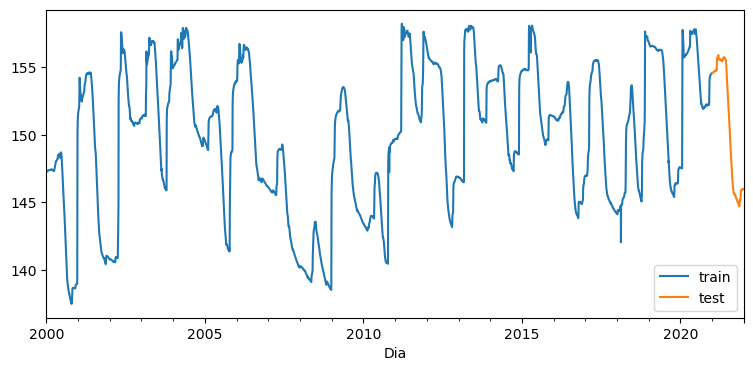

In [129]:
# Separació dades train-test
# ==============================================================================

steps = 365
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

# gràfica del train i test
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['Nivell absolut (msnm)'].plot(ax=ax, label='train')
datos_test['Nivell absolut (msnm)'].plot(ax=ax, label='test')
ax.legend()

## Ridge

In [134]:
# Crear forecaster
# ==============================================================================
forecaster_ridge_exog = ForecasterAutoreg(
                regressor = Ridge(alpha = 5.0, max_iter = 100, random_state=42),
                lags = 6180
             )

forecaster_ridge_exog.fit(y=datos_train['Nivell absolut (msnm)'], exog=datos_train['PPT'])
forecaster_ridge_exog

ForecasterAutoreg 
Regressor: Ridge(alpha=5.0, max_iter=100, random_state=42) 
Lags: [   1    2    3 ... 6178 6179 6180] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6180 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: PPT 
Training range: [Timestamp('2000-01-01 00:00:00'), Timestamp('2021-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 5.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 100, 'normalize': 'deprecated', 'positive': False, 'random_state': 42, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2023-01-18 23:32:44 
Last fit date: 2023-01-18 23:32:45 
Skforecast version: 0.6.0 
Python version: 3.9.13 

In [135]:
# Prediccions
# ==============================================================================
steps = 365
predicciones_ridge_exog = forecaster_ridge_exog.predict(steps=steps, exog=datos_test['PPT'])

In [136]:
# Metriques
# ==============================================================================
error_mse_rbx = mean_squared_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_ridge_exog
            )
error_mae_rbx = mean_absolute_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_ridge_exog
            )
score_rbx = r2_score(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_ridge_exog
            )
print(f"Error de test (mae): {error_mae_rbx}")
print(f"Error de test (mse): {error_mse_rbx}")
print(f"R2 Score: {score_rbx}")

Error de test (mae): 1.6702572511695015
Error de test (mse): 5.586968120312772
R2 Score: 0.7263514162176277


## LinearRegression

In [137]:
# Crear forecaster
# ==============================================================================
forecaster_lr_exog = ForecasterAutoreg(
                regressor = LinearRegression(n_jobs=10),
                lags = 6180
             )

forecaster_lr_exog.fit(y=datos_train['Nivell absolut (msnm)'], exog=datos_train['PPT'])
forecaster_lr_exog

ForecasterAutoreg 
Regressor: LinearRegression(n_jobs=10) 
Lags: [   1    2    3 ... 6178 6179 6180] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6180 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: PPT 
Training range: [Timestamp('2000-01-01 00:00:00'), Timestamp('2021-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': 10, 'normalize': 'deprecated', 'positive': False} 
Creation date: 2023-01-18 23:33:26 
Last fit date: 2023-01-18 23:33:30 
Skforecast version: 0.6.0 
Python version: 3.9.13 

In [138]:
# Prediccions
# ==============================================================================
steps = 365
predicciones_lr_exog = forecaster_lr_exog.predict(steps=steps, exog=datos_test['PPT'])

In [147]:
# Metriques
# ==============================================================================
error_mse_lrx = mean_squared_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_lr_exog
            )
error_mae_lrx = mean_absolute_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_lr_exog
            )
score_lrx = r2_score(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_lr_exog
            )
print(f"Error de test (mae): {error_mae_lrx}")
print(f"Error de test (mse): {error_mse_lrx}")
print(f"R2 Score: {score_lrx}")

Error de test (mae): 1.615321621554624
Error de test (mse): 5.338831531329344
R2 Score: 0.7385050968361064


## PassiveAggressiveRegressor

In [140]:
# Crear i entrenar forecaster
# ==============================================================================
forecaster_PAR_exog = ForecasterAutoreg(
                regressor =  PassiveAggressiveRegressor(loss='squared_epsilon_insensitive', epsilon= 0.2, random_state=42),
                lags = 6180,
                #transformer_y = MinMaxScaler()
             )

forecaster_PAR_exog.fit(y=datos_train['Nivell absolut (msnm)'] , exog=datos_train['PPT'])
forecaster_PAR_exog 

ForecasterAutoreg 
Regressor: PassiveAggressiveRegressor(epsilon=0.2, loss='squared_epsilon_insensitive',
                           random_state=42) 
Lags: [   1    2    3 ... 6178 6179 6180] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6180 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: PPT 
Training range: [Timestamp('2000-01-01 00:00:00'), Timestamp('2021-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'C': 1.0, 'average': False, 'early_stopping': False, 'epsilon': 0.2, 'fit_intercept': True, 'loss': 'squared_epsilon_insensitive', 'max_iter': 1000, 'n_iter_no_change': 5, 'random_state': 42, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-01-18 23:34:19 
Last fit date: 2023-01-18 23:34:21 
Skforecast version: 0.6.0 
Python version: 3.

In [142]:
# Prediccions
# ==============================================================================
steps = 365
predicciones_PAR_exog = forecaster_PAR_exog.predict(steps=steps, exog=datos_test['PPT'])

In [145]:
# Metriques
# ==============================================================================
error_mse_PARx = mean_squared_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_PAR_exog
            )
error_mae_PARx = mean_absolute_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_PAR_exog
            )
score_PARx = r2_score(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_PAR_exog
            )
print(f"Error de test (mae): {error_mae_PARx}")
print(f"Error de test (mse): {error_mse_PARx}")
print(f"R2 Score: {score_PARx}")

Error de test (mae): 1.482817754127311
Error de test (mse): 4.8201441543673
R2 Score: 0.7639103010676119


In [171]:
metrics = {'Model': ['Linear Regression', 'Ridge', 'Passive Agressive',  'Linear Regression Best', 'Ridge Best', 'Passive Agressive Best'],
           'MAE': [error_mae_lr, error_mae_ridge, error_mae_PAR,  error_mae_lrb, error_mae_rb, error_mae_PARb],
           'MSE': [error_mse_lr, error_mse_ridge, error_mse_PAR,  error_mse_lrb, error_mse_rb, error_mse_PARb],
        'R2': [score_lr, score_ridge, score_PAR, score_lrb, score_rb, score_PARb]}

resultats = pd.DataFrame(data=metrics)

resultats

,Model,MAE,MSE,R2
0,Linear Regression,1.620418,5.354497,0.737738
1,Ridge,1.681641,5.624012,0.724537
2,Passive Agressive,1.528258,5.035074,0.753383
3,Linear Regression Best,1.620418,5.354497,0.737738
4,Ridge Best,1.676788,5.611851,0.725133
5,Passive Agressive Best,1.483316,4.822003,0.763819


In [152]:
metrics2 = {'Model': ['Linear Regression Exog', 'Ridge Exog', 'Passive Agressive Exog'],
           'MAE': [error_mae_lrx, error_mae_rbx, error_mae_PARx],
           'MSE': [error_mse_lrx, error_mse_rbx, error_mse_PARx],
        'R2': [score_lrx, score_rbx, score_PARx]}

resultats2 = pd.DataFrame(data=metrics2)

resultats2

,Model,MAE,MSE,R2
0,Linear Regression Exog,1.615322,5.338832,0.738505
1,Ridge Exog,1.670257,5.586968,0.726351
2,Passive Agressive Exog,1.482818,4.820144,0.763910


Com podem veure el fet d'afegir una variable exògena amb tan poca correlació com és en aquest cas la precipitació, no ens ha ajudat a millorar gaire les nostres metriques com era d'esperar. En el cas del MAE  l'ha disminuit  al voltant de 0,005, i el MSE sobre el 0,01. Mentres que en el cas del R2 ha augmentat un mínim de 0,01 en el cas del PassiveAgressiveRegressor i un màxim de 0,12 en el Ridge regressor.

## Predicció a dos anys

Després d'haver provat els nostres models a un any vista i haver comprovat que obtenim bones prediccions, veurem quins resultats ens donen quan li demanem prediccions a dos anys.

In [172]:
datos = pd.read_csv('df/db_df.csv')

datos.drop(['Percentatge volum embassat (%)'], axis = 'columns', inplace=True)
datos.drop(['Volum embassat (hm3)'], axis = 'columns', inplace=True)

datos['Dia'] = pd.to_datetime(datos['Unnamed: 0'], format='%Y/%m/%d')
datos = datos.set_index('Dia')
datos = datos.asfreq('D')
datos = datos.sort_index()
datos.drop(['Unnamed: 0'], axis = 'columns', inplace=True)

In [173]:
datos.head()

,Nivell absolut (msnm),PPT
Dia,,
2000-01-01,147.27,0.0
2000-01-02,147.27,0.0
2000-01-03,147.27,0.0
2000-01-04,147.27,0.0
2000-01-05,147.28,0.0


Fechas train : 2000-01-01 00:00:00 --- 2020-12-13 00:00:00  (n=7653)
Fechas test  : 2020-12-14 00:00:00 --- 2022-12-13 00:00:00  (n=730)


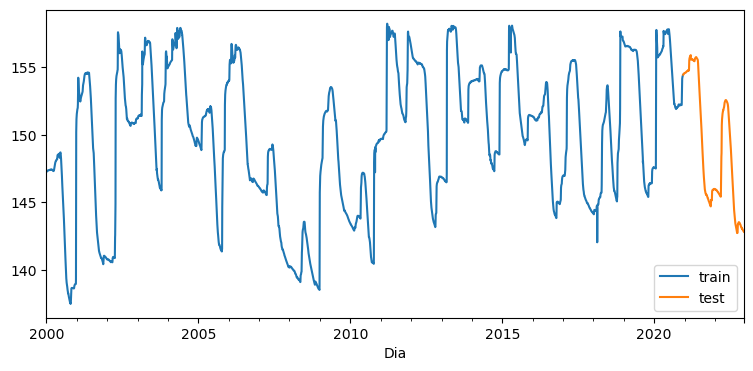

In [178]:
# Separació dades train-test
# ==============================================================================

steps = 730
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

# gràfica del train i test
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['Nivell absolut (msnm)'].plot(ax=ax, label='train')
datos_test['Nivell absolut (msnm)'].plot(ax=ax, label='test')
ax.legend()

Comencem amb el model Linear Regression.

In [206]:
# Crear forecaster
# ==============================================================================
forecaster_lr2 = ForecasterAutoreg(
                regressor = LinearRegression(n_jobs=10),
                lags = 6182
             )

forecaster_lr2.fit(y=datos_train['Nivell absolut (msnm)'], exog=datos_train['PPT'])
forecaster_lr2

ForecasterAutoreg 
Regressor: LinearRegression(n_jobs=10) 
Lags: [   1    2    3 ... 6180 6181 6182] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6182 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: PPT 
Training range: [Timestamp('2000-01-01 00:00:00'), Timestamp('2020-12-13 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': 10, 'normalize': 'deprecated', 'positive': False} 
Creation date: 2023-01-31 13:15:27 
Last fit date: 2023-01-31 13:15:30 
Skforecast version: 0.6.0 
Python version: 3.9.13 

In [207]:
# Prediccions
# ==============================================================================
steps = 730
predicciones_lr2 = forecaster_lr2.predict(steps=steps, exog=datos_test['PPT'])

In [208]:
# Metriques
# ==============================================================================
error_mse_lr2 = mean_squared_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_lr2
            )
error_mae_lr2 = mean_absolute_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_lr2
            )
score_lr2 = r2_score(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_lr2
            )
print(f"Error de test (mse): {error_mae_lr2}")
print(f"Error de test (mse): {error_mse_lr2}")
print(f"R2 Score: {score_lr2}")

Error de test (mse): 3.71790666597437
Error de test (mse): 21.381376162055307
R2 Score: -0.032150782138601786


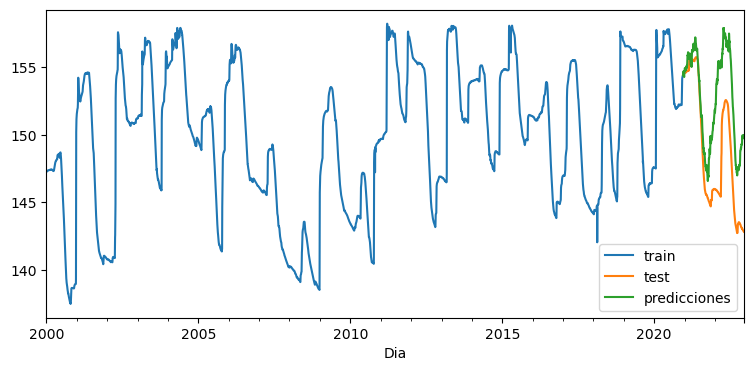

In [193]:
# Gràfic
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['Nivell absolut (msnm)'].plot(ax=ax, label='train')
datos_test['Nivell absolut (msnm)'].plot(ax=ax, label='test')
predicciones_lr2.plot(ax=ax, label='predicciones')
ax.legend();

A continuació provarem el model Ridge.

In [184]:
# Crear forecaster
# ==============================================================================
forecaster_ridge2 = ForecasterAutoreg(
                regressor = Ridge(alpha = 5.0, max_iter = 100, random_state=42),
                lags = 6182
             )

forecaster_ridge2.fit(y=datos_train['Nivell absolut (msnm)'], exog=datos_train['PPT'])
forecaster_ridge2

ForecasterAutoreg 
Regressor: Ridge(alpha=5.0, max_iter=100, random_state=42) 
Lags: [   1    2    3 ... 6180 6181 6182] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6182 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: PPT 
Training range: [Timestamp('2000-01-01 00:00:00'), Timestamp('2020-12-13 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 5.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 100, 'normalize': 'deprecated', 'positive': False, 'random_state': 42, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2023-01-31 13:11:59 
Last fit date: 2023-01-31 13:12:00 
Skforecast version: 0.6.0 
Python version: 3.9.13 

In [185]:
# Prediccions
# ==============================================================================
steps =730
predicciones_ridge2 = forecaster_ridge2.predict(steps=steps, exog=datos_test['PPT'])

In [186]:
# Metriques
# ==============================================================================
error_mse_r2 = mean_squared_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_ridge2
            )
error_mae_r2 = mean_absolute_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_ridge2
            )
score_r2 = r2_score(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_ridge2
            )
print(f"Error de test (mse): {error_mae_r2}")
print(f"Error de test (mse): {error_mse_r2}")
print(f"R2 Score: {score_r2}")

Error de test (mse): 3.8326188652485005
Error de test (mse): 22.397624563785158
R2 Score: -0.08120850296735038


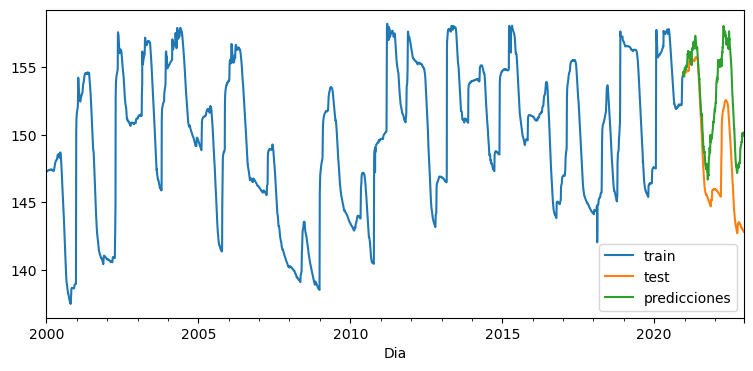

In [187]:
# Gràfic
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['Nivell absolut (msnm)'].plot(ax=ax, label='train')
datos_test['Nivell absolut (msnm)'].plot(ax=ax, label='test')
predicciones_ridge2.plot(ax=ax, label='predicciones')
ax.legend();

Finalment farem servir el nostre millor model PassiveAgressiveRegressor.

In [188]:
# Crear i entrenar forecaster
# ==============================================================================
forecaster_PAR2 = ForecasterAutoreg(
                regressor =  PassiveAggressiveRegressor(loss='squared_epsilon_insensitive', epsilon= 0.2, random_state=42),
                lags = 6182,
                #transformer_y = MinMaxScaler()
             )

forecaster_PAR2.fit(y=datos_train['Nivell absolut (msnm)'], exog=datos_train['PPT'])
forecaster_PAR2 

ForecasterAutoreg 
Regressor: PassiveAggressiveRegressor(epsilon=0.2, loss='squared_epsilon_insensitive',
                           random_state=42) 
Lags: [   1    2    3 ... 6180 6181 6182] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6182 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: PPT 
Training range: [Timestamp('2000-01-01 00:00:00'), Timestamp('2020-12-13 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'C': 1.0, 'average': False, 'early_stopping': False, 'epsilon': 0.2, 'fit_intercept': True, 'loss': 'squared_epsilon_insensitive', 'max_iter': 1000, 'n_iter_no_change': 5, 'random_state': 42, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-01-31 13:12:22 
Last fit date: 2023-01-31 13:12:24 
Skforecast version: 0.6.0 
Python version: 3.

In [189]:
# Prediccions
# ==============================================================================
steps = 730
predicciones_PAR2 = forecaster_PAR2.predict(steps=steps, exog=datos_test['PPT'])

In [190]:
# Metriques
# ==============================================================================
error_mse_PAR2 = mean_squared_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_PAR2
            )
error_mae_PAR2 = mean_absolute_error(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_PAR2
            )
score_PAR2 = r2_score(
                y_true = datos_test['Nivell absolut (msnm)'],
                y_pred = predicciones_PAR2
            )
print(f"Error de test (mae): {error_mae_PAR2}")
print(f"Error de test (mse): {error_mse_PAR2}")
print(f"R2 Score: {score_PAR2}")

Error de test (mae): 2.974014753840548
Error de test (mse): 12.37421721565828
R2 Score: 0.4026550077650888


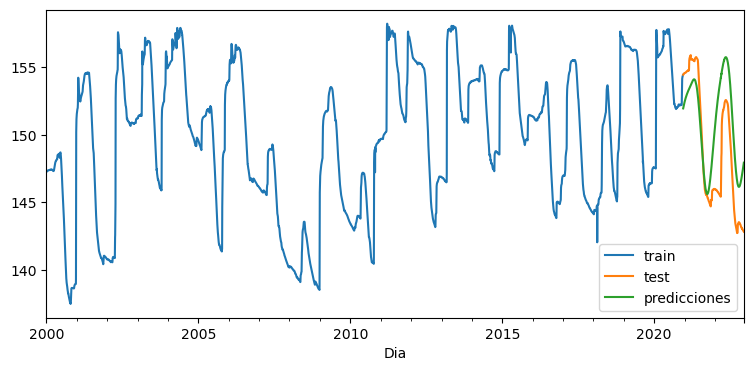

In [191]:
# Gràfic
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['Nivell absolut (msnm)'].plot(ax=ax, label='train')
datos_test['Nivell absolut (msnm)'].plot(ax=ax, label='test')
predicciones_PAR2.plot(ax=ax, label='predicciones')
ax.legend();

In [192]:
metrics3 = {'Model': ['Linear Regression 2 anys', 'Ridge 2 anys', 'Passive Agressive 2 anys'],
           'MAE': [error_mae_lr2, error_mae_r2, error_mae_PAR2],
           'MSE': [error_mse_lr2, error_mse_r2, error_mse_PAR2],
        'R2': [score_lr2, score_r2, score_PAR2]}

resultats3 = pd.DataFrame(data=metrics3)

resultats3

,Model,MAE,MSE,R2
0,Linear Regression 2 anys,3.717907,21.381376,-0.032151
1,Ridge 2 anys,3.832619,22.397625,-0.081209
2,Passive Agressive 2 anys,2.974015,12.374217,0.402655


Podem concloure que en prediccions a dos anys la precissió en la predicció baixa considerablament, i també podem comprovar com quan hi ha una baixada sobtada el model no és capaç de predir-la. Així que en cas d'inundacions o sequeres que comportarien pujades o baixades notables del nivell de l'embassament, els nostres models no serien capaços de predir-les.

Continua al notebook ARIMA-->